# ODE Integrators II: Implicit and Symplectic Methods [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ua-2025q3-astr501-513/ua-2025q3-astr501-513.github.io/blob/main/513/09/notes.ipynb)

## Convergence of Integrators

When solving ordinary differential equations (ODEs) numerically,
errors inevitably enter through truncation (e.g., approximating
derivatives with finite differences) and round-off (finite precision
arithmetic).
If these errors grow uncontrollably, the computed solution may diverge
from the true behavior, even if the method is very accurate for short
times.

It is useful to distinguish between several related ideas:
* Accuracy:
  How close the numerical solution is to the exact solution at a given
  time step.
* Consistency:
  The numerical method reproduces the original ODE as
  $\Delta t \to 0$.
  Formally, the local truncation error (the error made in a single
  step assuming exact input) should vanish as $\Delta t \to 0$.
* Stability:
  Errors introduced during computation do not grow uncontrollably as
  steps are repeated.
* Convergence:
  The global numerical solution approaches the exact solution as
  $\Delta t \to 0$.

These concepts are related by a central result of numerical analysis:
\begin{align}
  \text{Consistency + Stability } \implies \text{ Convergence.}
\end{align}

This is known as the
[Lax Equivalence Theorem](https://en.wikipedia.org/wiki/Lax_equivalence_theorem).
The theorem is really for linear finite difference methods for partial
different equation, but it is still useful to discuss it in ODE
integrator.
It gives us a practical recipe:
* First check that the method is consistent (usually straightforward).
* Then analyze stability, we usually use the linear test equation:
  \begin{align}
    \frac{dx}{dt} = \lambda x, \quad \lambda \in \mathbb{C}.
  \end{align}
  Its exact solution is $x(t) = x_0 e^{\lambda t}$.
  Applying a numerical method produces an update:
  \begin{align}
    x_{n+1} = R(z) x_n, \quad z = \lambda \Delta t,
  \end{align}
  where $R(z)$ is the amplification factor.
  A method is stable if
  \begin{align}
    |R(z)| \leq 1,
  \end{align}
  so that errors do not amplify step by step.
  The set of $z$ satisfying this condition defines the stability region.
* Convergence then follows automatically.

## Explicit Methods

### Forward Euler Stability and Consistency

The Forward Euler method for $dx/dt = f(x)$ is
\begin{align}
  x_{n+1} = x_n + \Delta t f(x_n).
\end{align}
Expanding the true solution with a Taylor series:
\begin{align}
  x(t_{n+1}) = x(t_n + \Delta t) = x(t_n) + \Delta t f(x_n) + \frac{1}{2} \Delta t^2 f'(x_n) + \mathcal{O}(\Delta t^3)
\end{align}

The difference between the true solution and the Forward Euler step is
$\mathcal{O}(\Delta t^2)$.
Thus, the local truncation error is $\mathcal{O}(\Delta t^2)$, meaning
the method is first-order consistent.

Applying the test equation to forward Euler method gives:
\begin{align}
  x_{n+1} = (1 + \lambda \Delta t) x_n,
\end{align}
so the amplification factor is
\begin{align}
  R(z) = 1 + z, \quad z = \lambda \Delta t.
\end{align}

The stability condition requires
\begin{align}
  |1 + z| \leq 1,
\end{align}
which is the interior of the circle centered at $(-1,0)$ with radius 1
in the complex plane.

In [1]:
import numpy as np

# Define grid in complex plane
Re = np.linspace(-3, 3, 601)
Im = np.linspace(-3, 3, 601)

Re, Im = np.meshgrid(Re, Im)
Z = Re + 1j * Im

In [2]:
# Forward Euler amplification factor

RfE = lambda z: abs(1 + z)

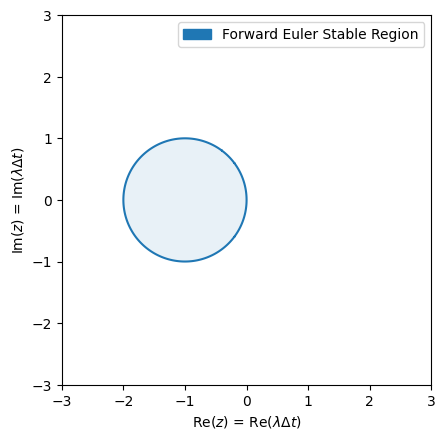

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.contour (Re, Im, RfE(Z), levels=[1],   colors=['C0'])
plt.contourf(Re, Im, RfE(Z), levels=[0,1], colors=['C0'], alpha=0.1)

plt.legend(handles=[
    mpatches.Patch(color='C0', label="Forward Euler Stable Region"),
])

plt.xlabel(r"Re($z$) = Re($\lambda\Delta t$)")
plt.ylabel(r"Im($z$) = Im($\lambda\Delta t$)")
plt.gca().set_aspect('equal')

Combined with stability, forward Euler is first-order convergent,
i.e., the global error scales as $\mathcal{O}(\Delta t)$, within its
stable region.
Outside the stable region, the method diverges.

#### Exponential Decay

To illustrate stability and convergence, let's recall the forward
Euler scheme we implemented last time, except we allow explicit
time dependency in the right hand side of the function.

In [4]:
def forwardEuler(f, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    for _ in range(n):
        X.append(X[-1] + dt * f(X[-1], T[-1]))
        T.append(T[-1] + dt)
    return np.array(X), np.array(T)

We apply it to solve the equation $dx/dt = -x$, which has $\lambda =
-1$ and solution $\exp(-t)$.

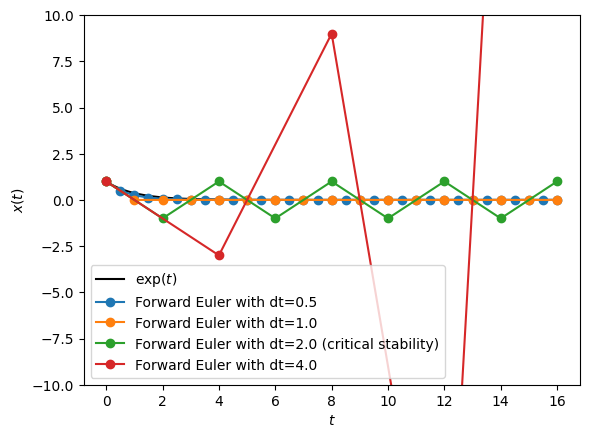

In [5]:
f = lambda x, t: -x
t = 16
T = np.linspace(0, t, t*100+1)
X = np.exp(-T)

n = 32; X11, T11 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
n = 16; X12, T12 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
n = 8;  X13, T13 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
n = 4;  X14, T14 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)

plt.plot(T,   X,   'k',    label=r"$\exp(t)$")
plt.plot(T11, X11, "C0o-", label=f"Forward Euler with dt={t/32}")
plt.plot(T12, X12, "C1o-", label=f"Forward Euler with dt={t/16}")
plt.plot(T13, X13, "C2o-", label=f"Forward Euler with dt={t/8} (critical stability)")
plt.plot(T14, X14, "C3o-", label=f"Forward Euler with dt={t/4}")
plt.xlabel(r"$t$")
plt.ylabel(r"$x(t)$")
plt.ylim(-10, 10)
plt.legend()

The error for $\Delta t = 4$ grows unbounded.
Even at the critical stability step size $\Delta t = 2$, the
oscillating behavior is fundamentally wrong.
Nevertheless, as $\Delta t \rightarrow 0$, especially when
$\Delta t < -2/\lambda$ the solution does convergence.

However, if $\lambda$ is positive, there is no positive $\Delta t$
that can make forward Euler stable.
And we call forward Euler unconditionally unstable.

This suggests that,
* Consistency:
  Forward Euler has local error $\mathcal{O}(\Delta t^2)$.
* Stability:
  Stable only inside the unit disk centered at $(-1,0)$.
* Convergence:
  By Lax's theorem, Forward Euler converges with global error
  $\mathcal{O}(\Delta t)$.

Implications:
* For $\lambda < 0$ (decaying solutions), stability requires
  $\Delta t \leq -2/\lambda$.
* For $\lambda > 0$ (growing solutions), Forward Euler is
  unconditionally unstable: no choice of $\Delta t$ can control error
  growth.
* For stiff systems, where $|\lambda|$ is very large, the step size
  restriction is too severe to be practical.

This motivates the need for implicit integrators (Backward Euler,
trapezoidal rule) and later symplectic integrators for Hamiltonian
systems.

#### Simple Harmonic Oscillator

The exponential test equation matches the linear test equation and is
a good illustrative example, but many physical systems of interest are
naturally written as systems of coupled ODEs.

Recalling again from last lecture, an important example is the simple
harmonic oscillator:
\begin{align}
  \frac{d}{dt}
  \begin{bmatrix}
    \theta(t) \\
    \Omega(t)
  \end{bmatrix}
  =
  \begin{bmatrix}
    0    & 1 \\
    -g/l & 0
  \end{bmatrix}
  \begin{bmatrix}
    \theta(t) \\
    \Omega(t)
  \end{bmatrix}.
\end{align}
Here $\theta(t)$ is the angular displacement, $\Omega(t)$ the angular
velocity, and $g/l$ sets the natural frequency $\omega^2 = g/l$.


Applying the Forward Euler method gives:
\begin{align}
  \begin{bmatrix}
    \theta_{n+1} \\
    \Omega_{n+1}
  \end{bmatrix}
  =
  \begin{bmatrix}
    \theta_{n} \\
    \Omega_{n}
  \end{bmatrix}
  +
  \Delta t
  \begin{bmatrix}
    0 & 1 \\
    -g/l & 0
  \end{bmatrix}
  \begin{bmatrix}
    \theta_{n} \\
    \Omega_{n}
  \end{bmatrix}.
\end{align}

This can be written compactly as:
\begin{align}
  \mathbf{x}_{n+1} = A \mathbf{x}_n, \quad
  A =
  \begin{bmatrix}
    1              & \Delta t \\
    -(g/l)\Delta t & 1
  \end{bmatrix}.
\end{align}

Here $A$ is the amplification matrix, the multi-dimensional analogue
of the scalar amplification factor $R(z)$.
Stability requires that the eigenvalues of $A$ satisfy
$|\lambda| \leq 1$.

Let's compute them.
The characteristic polynomial of $A$ is:
\begin{align}
  \det(A - \lambda I) =
  \begin{vmatrix}
  1 - \lambda    & \Delta t \\
  -(g/l)\Delta t & 1 - \lambda
  \end{vmatrix}
  = (1-\lambda)^2 + \frac{g}{l} \Delta t^2.
\end{align}

Setting this to zero,  $(1 - \lambda)^2 = -(g/l)\Delta t^2$.
Thus the eigenvalues are:
\begin{align}
  \lambda_{\pm} = 1 \pm i \sqrt{\frac{g}{l}} \Delta t.
\end{align}

The magnitude of each eigenvalue is:
\begin{align}
  |\lambda_{\pm}| = \sqrt{1 + \frac{g}{l} \Delta t^2}.
\end{align}
This is always larger than 1 for any nonzero time step.
Therefore, Forward Euler applied to the harmonic oscillator is
unconditionally unstable.

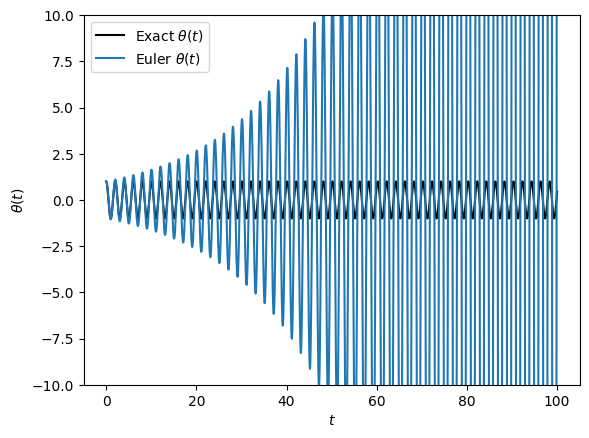

In [6]:
# Parameters
g, l = 9.8, 1
t, n = 100, 10000

def Sho(x, t):
    theta, omega = x
    return np.array([omega, -(g/l) * theta])

def sho_solution(t):
    return np.cos(np.sqrt(g/l)*t)

T     = np.linspace(0, t, t*100+1)
Theta = sho_solution(T)

X1, T1 = forwardEuler(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta1, Omega1 = X1[:,0], X1[:,1]

plt.plot(T,  Theta, 'k', label=r"Exact $\theta(t)$")
plt.plot(T1, Theta1,     label=r"Euler $\theta(t)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\theta(t)$")
plt.ylim(-10, 10)
plt.legend()

In [7]:
# HANDSON: try increase the number of time step per period.
#          Does this stop the oscillator from blowing up?


The true solution of the harmonic oscillator is bounded and
oscillatory.
However, the forward Euler discretization produces eigenvalues with
modulus larger than 1.
This means that the numerical solution grows exponentially in
amplitude while also oscillating.
This "blow up" happens even for very small $\Delta t$.

In [8]:
# HANDSON: try plotting the energy of the oscillator.


For the harmonic oscillator, Forward Euler is inconsistent with the
bounded, energy-conserving nature of the physics.
In fact,
* Explicit (forward)  Euler introduces artificial growth  of energy.
* Implicit (backward) Euler introduces artificial damping of energy.
* Symplectic integrators (e.g., Leapfrog, see below) preserve the
  energy structure and produce qualitatively correct long-term
  behavior.

This example connects stability analysis directly to physics:
the choice of integrator is not just about error size, but about
preserving the qualitative features of the dynamics.

### Stability Regions for RK2 and RK4

So far we have analyzed the forward Euler method, which is simple but
has a very restrictive stability region.
In practice, physicists often use higher-order explicit Runge-Kutta
(RK) methods, such as RK2 and RK4.
These methods improve accuracy while also enlarging the stability
region, allowing for larger time steps in many problems.

To analyze stability, we again apply the methods to the linear test equation:
\begin{align}
  \frac{dx}{dt} = \lambda x, \quad z = \lambda \Delta t.
\end{align}
Each Runge-Kutta scheme can be written in the form:
\begin{align}
  x_{n+1} = R(z) x_n,
\end{align}
where $R(z)$ is the stability function of the method.
Stability requires $|R(z)| \leq 1$.
* Forward Euler (for comparison):
  \begin{align}
    R_{\text{fE}}(z) = 1 + z
  \end{align}
* RK2 (Heun's method):
  \begin{align}
    R_{\text{RK2}}(z) = 1 + z + \tfrac{1}{2} z^2
  \end{align}
* RK4 (classical Runge–Kutta):
  \begin{align}
    R_{\text{RK4}}(z) = 1 + z + \tfrac{1}{2} z^2 + \tfrac{1}{6} z^3 + \tfrac{1}{24} z^4
  \end{align}

Notice:
$R_{\text{RK4}}(z)$ is simply the first four terms of the Taylor
expansion of $e^z$, which explains why RK4 is accurate to fourth
order.

In [9]:
# Stability functions
RfE  = lambda z: abs(1 + z)  # the same as before, for comparison only
RRK2 = lambda z: abs(1 + z + 0.5 * z**2)
RRK4 = lambda z: abs(1 + z + 0.5 * z**2 + (1/6) * z**3 + (1/24) * z**4)

# Plot regions
methods = {
    'Forward Euler': (RfE,  'C0'),
    'RK2':           (RRK2, 'C1'),
    'RK4':           (RRK4, 'C2'),
}

In [10]:
def stable_regions(methods):
    for name, (R, color) in methods.items():
        plt.contour (Re, Im, R(Z), levels=[1],   colors=[color])
        plt.contourf(Re, Im, R(Z), levels=[0,1], colors=[color], alpha=0.1)

    plt.legend(handles=[
        mpatches.Patch(color=color, label=name) for name, (_,color) in methods.items()
    ])

    plt.xlabel(r"Re($z$) = Re($\lambda\Delta t$)")
    plt.ylabel(r"Im($z$) = Im($\lambda\Delta t$)")
    plt.gca().set_aspect('equal')

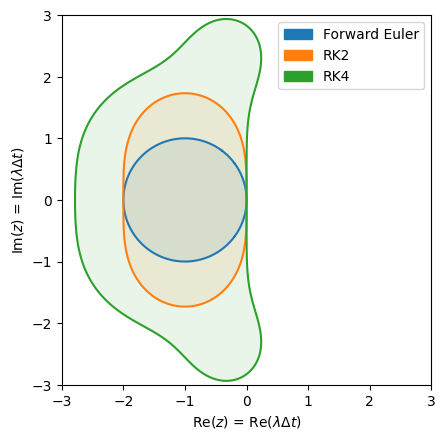

In [11]:
stable_regions(methods)

Some observations from the above plot:
* Forward Euler:
  * Stability region:
    disk of radius 1 centered at $(-1,0)$.
  * Very restrictive:
    only stable for very small $\Delta t$ when $\lambda$ has a
    negative real part.
* RK2
  * Stability region:
    significantly larger, extending farther left into the negative
    real axis.
  * Stable for $\text{Re}(z) \gtrsim -2$.
  * This allows larger time steps for decaying problems, while still
    being conditionally stable.
* RK4
  * Stability region:
    even larger, extending roughly to $\text{Re}(z) \approx -2.8$ on
    the real axis.
  * Includes a more extensive area in the complex plane, meaning
    oscillatory systems can tolerate larger $\Delta t$ before
    instability.
  * Most widely used in physics and engineering because of its balance
    between accuracy and stability.

In [12]:
def RK2(f, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    for _ in range(n):
        k1 = f(X[-1],             T[-1]         )
        k2 = f(X[-1] + 0.5*dt*k1, T[-1] + 0.5*dt)
        X.append(X[-1] + dt * k2)
        T.append(T[-1] + dt     )
    return np.array(X), np.array(T)

In [13]:
def RK4(f, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    for _ in range(n):
        k1 = f(X[-1]            , T[-1]         )
        k2 = f(X[-1] + 0.5*dt*k1, T[-1] + 0.5*dt)
        k3 = f(X[-1] + 0.5*dt*k2, T[-1] + 0.5*dt)
        k4 = f(X[-1] +     dt*k3, T[-1] +     dt)
        X.append(X[-1] + dt * (k1/6 + k2/3 + k3/3 + k4/6))
        T.append(T[-1] + dt)
    return np.array(X), np.array(T)

In [14]:
t = 16
T = np.linspace(0, t, t*100+1)
X = np.exp(-T)

n = 9
X11, T11 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
X21, T21 = RK2         (f, x=1, t=0, dt=t/n, n=n)
X41, T41 = RK4         (f, x=1, t=0, dt=t/n, n=n)

n = 8
X12, T12 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
X22, T22 = RK2         (f, x=1, t=0, dt=t/n, n=n)
X42, T42 = RK4         (f, x=1, t=0, dt=t/n, n=n)

n = 6
X13, T13 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
X23, T23 = RK2         (f, x=1, t=0, dt=t/n, n=n)
X43, T43 = RK4         (f, x=1, t=0, dt=t/n, n=n)

n = 5
X14, T14 = forwardEuler(f, x=1, t=0, dt=t/n, n=n)
X24, T24 = RK2         (f, x=1, t=0, dt=t/n, n=n)
X44, T44 = RK4         (f, x=1, t=0, dt=t/n, n=n)

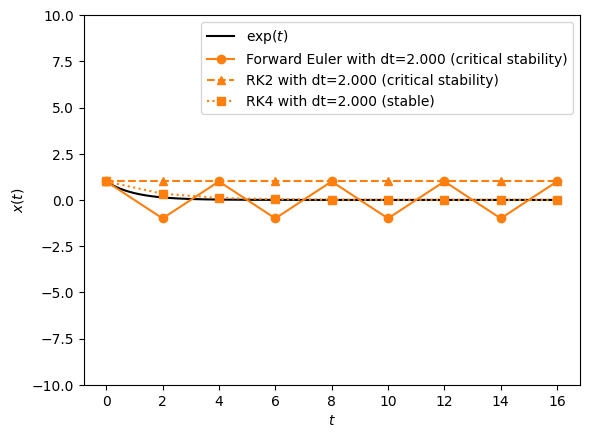

In [15]:
plt.plot(T,   X,   'k',    label=r"$\exp(t)$")

#plt.plot(T11, X11, "C0o-", label=f"Forward Euler with dt={t/9:.3f} (stable)")
plt.plot(T12, X12, "C1o-", label=f"Forward Euler with dt={t/8:.3f} (critical stability)")
#plt.plot(T13, X13, "C2o-", label=f"Forward Euler with dt={t/6:.3f} (unstable)")
#plt.plot(T14, X14, "C3o-", label=f"Forward Euler with dt={t/5:.3f} (unstable)")

#plt.plot(T21, X21, "C0^--", label=f"RK2 with dt={t/9:.3f} (stable)")
plt.plot(T22, X22, "C1^--", label=f"RK2 with dt={t/8:.3f} (critical stability)")
#plt.plot(T23, X23, "C2^--", label=f"RK2 with dt={t/6:.3f} (unstable)")
#plt.plot(T24, X24, "C3^--", label=f"RK2 with dt={t/5:.3f} (unstable)")

#plt.plot(T41, X41, "C0s:", label=f"RK4 with dt={t/9:.3f} (stable)")
plt.plot(T42, X42, "C1s:", label=f"RK4 with dt={t/8:.3f} (stable)")
#plt.plot(T43, X43, "C2s:", label=f"RK4 with dt={t/6:.3f} (stable)")
#plt.plot(T44, X44, "C3s:", label=f"RK4 with dt={t/5:.3f} (unstable)")

plt.xlabel(r"$t$")
plt.ylabel(r"$x(t)$")
plt.ylim(-10, 10)
plt.legend()

In [16]:
# HANDSON: comment and uncomment different curves to study them.


In general,
* Order vs. Stability:
  Higher-order RK methods expand the stability region, allowing larger
  $\Delta t$ while maintaining stability.
* Still Conditionally Stable:
  Neither RK2 nor RK4 are
  [A-stable](https://en.wikipedia.org/wiki/Stiff_equation#A-stability).
  They cannot remain stable for arbitrarily stiff problems (where
  $\lambda$ is very negative).
* Physics Implication:
  * For non-stiff problems (e.g. orbital dynamics, wave propagation),
    RK4 is an excellent choice.
  * For stiff problems (e.g. radiative cooling, chemical networks),
    even RK4 will fail unless $\Delta t$ is extremely small.
    These problems require implicit methods.

## Implicit Methods

So far we have focused on explicit methods such as forward Euler, RK2,
and RK4.
They are simple, intuitive, and accurate for many problems.
However, we also discovered:
* Forward Euler fails on oscillatory systems like the harmonic
  oscillator (unconditionally unstable).
* Explicit RK methods extend the stability region, but they are still
  conditionally stable.
  They cannot handle arbitrarily stiff problems.

This raises a natural question:

> Can we design methods that remain stable even when
  $\lambda \Delta t$
  is very large and negative?

This leads us to implicit methods.


In explicit methods, the new state is computed directly from known
information,
\begin{align}
  x_{n+1} = \Phi(x_n, t_n, \Delta t).
\end{align}
Example includes forward Euler $x_{n+1} = x_n + \Delta t f(x_n, t_n)$.
This makes them cheap and easy per step, but with limited stability.

In implicit methods, the new state appears on both sides of the
equation
\begin{align}
  x_{n+1} = \Psi(x_n, x_{n+1}, t_n, \Delta t)
\end{align}
Hence, root finders are required at each step.
Example includes backward Euler $x_{n+1} = x_n + \Delta t f(x_{n+1},
t_{n+1})$.
This makes them expensive per step but has much larger stability
regions.
They are ideal for stiff systems.

### Backward Euler Method

The simplest implicit scheme is backward Euler, the implicit
counterpart to Forward Euler.
\begin{align}
  x_{n+1} = x_n + \Delta t \, f(x_{n+1}, t_{n+1}).
\end{align}

This requires solving an equation for $x_{n+1}$ at every step.

For its stability analysis with the linear test equation, we apply
backward Euler to $dx/dt = \lambda x$ and define $z = \lambda \Delta
t$.
Given the update rule,
\begin{align}
  x_{n+1} = x_n + \Delta t \lambda x_{n+1}.
\end{align}

Rearrange:
\begin{align}
  x_{n+1} = \frac{1}{1 - z} x_n,
\end{align}
the amplification factor is:
\begin{align}
  R(z) = \frac{1}{1 - z}.
\end{align}

The stability condition requires
\begin{align}
  |R(z)| = \left|\frac{1}{1-z}\right| \leq 1.
\end{align}

* If $\text{Re}(z) \leq 0$ (stable in the continuous system), this
  inequality always holds.
* Therefore, backward Euler is
  [A-stable](https://en.wikipedia.org/wiki/Stiff_equation#A-stability):
  stable for the entire left half-plane.

This is in stark contrast with forward Euler and explicit RK methods.

In [17]:
# Stability functions
RbE = lambda z: abs(1 / (abs(1-z) + 1e-308))  # trick to avoid divide by zero

# Add plot regions
methods['Backward Euler'] = (RbE, 'C3')

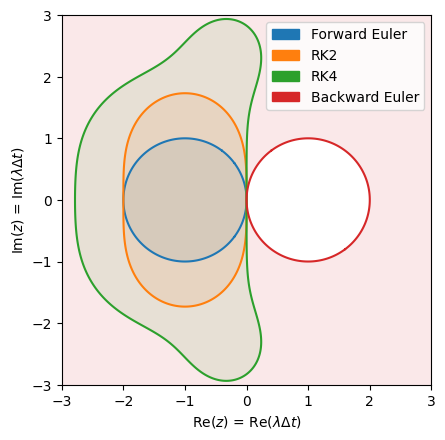

In [18]:
stable_regions(methods)

Implementing the backward Euler method involves solving an implicit
equation at each time step.
The approach depends on whether the ODE is linear or nonlinear.

* Linear ODEs:
  If $f(x, t)$ is linear in $x$, the implicit equation can be solved
  directly without iterative methods.
  For example, for $dx/dt = \lambda x$:
  \begin{align}
    x_{n+1} = (1 - \lambda \Delta t)^{-1} x_n.
  \end{align}
  Using matrix inverse, the above formulation even works for system of
  linear ODEs.

* Nonlinear ODEs:
  If $f(x, t)$ is nonlinear, solving for $x_{n+1}$ typically requires
  iterative methods such as the Newton-Raphson method.
  Python's `fsolve()` from the `scipy.optimize` library can also be
  used for this purpose.

### Stiff ODEs

Let's implement the backward Euler method for a simple linear ODE and
compare it with the forward Euler method.

Consider:
\begin{align}
  \frac{dx}{dt} = -1000x - 2000e^{-t} + 3000, \quad x(0) = 0
\end{align}
The exact solution is:
\begin{align}
  x(t) = 3 - 0.998 e^{-1000t} - 2.002 e^{-t}
\end{align}
This ODE is stiff because it contains terms with vastly different
decay rates ($e^{-1000t}$ vs. $e^{-t}$).


In [19]:
# Define the stiff ODE

def stiff(x, t):
    return -1000 * x - 2000 * np.exp(-t) + 3000

In [20]:
# Define the exact solution for comparison

def stiff_solution(t):
    return 3 - (3-2000/999) * np.exp(-1000 * t) - (2000/999) * np.exp(-t)

In [21]:
from scipy.optimize import fsolve

def backwardEuler(f, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    for _ in range(n):
        # Initial guess: Forward Euler estimate
        x0 = X[-1] + dt * f(X[-1], T[-1] + dt)
        
        # Define the implicit equation: x = x_last + dt * f(x, t)
        fim = lambda x: x - X[-1] - dt * f(x, T[-1] + dt)
        
        # Solve for x_next using Newton-Raphson (fsolve)
        x = fsolve(fim, x0)[0]
        
        X.append(x)
        T.append(T[-1] + dt)
    return np.array(X), np.array(T)

In [22]:
# Parameters
x0 = 0
t0 = 0
tf = 0.01  # short time to observe stiffness effects
dt = 0.0025

T = np.linspace(t0, tf, 1000)
X = stiff_solution(T)

XfE, TfE = forwardEuler (stiff, x0, t0, dt, int((tf-t0)//dt))
XbE, TbE = backwardEuler(stiff, x0, t0, dt, int((tf-t0)//dt))

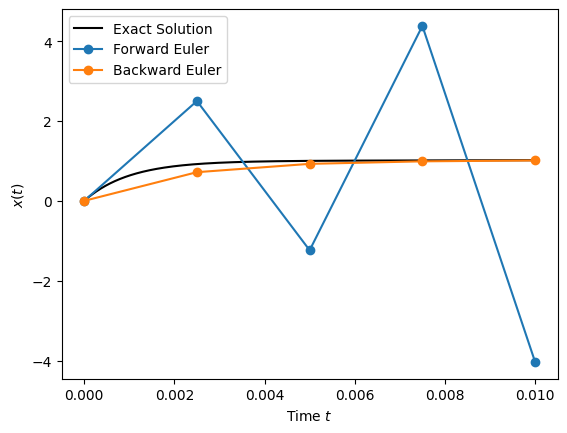

In [23]:
# Plotting
plt.plot(T,   X,   "k-",   label="Exact Solution")
plt.plot(TfE, XfE, "C0o-", label="Forward Euler")
plt.plot(TbE, XbE, "C1o-", label="Backward Euler")
plt.xlabel(r"Time $t$")
plt.ylabel(r"$x(t)$")
plt.legend()

In [24]:
# HANDSON: adjust dt and tf to observe the behaviors of forward and
#          backward Euler methods.
#          Specifically, try dt = 0.002, < 0.002, and > 0.002.


In [25]:
# HANDSON: apply backward Euler method to the simple harmonic
#          oscillator problem.
#          Plot evolution of energy as function of time.


In [26]:
# HANDONS: create convergence plots to show the order of forward and
#          backward Euler method for both the stiff problem and
#          harmonic oscillator problem.


The comparison between forward Euler and backward Euler highlights
their complementary strengths and weaknesses:

* Forward Euler is simple and inexpensive per step, but it fails badly
  on stiff problems.
  Even with small time steps, it can oscillate and diverge when
  fast-decaying modes are present.

* Backward Euler, in contrast, remains stable regardless of the step
  size for problems with $\text{Re}(\lambda) \leq 0$.
  This A-stability makes it ideally suited for stiff systems, where
  explicit schemes would require prohibitively small $\Delta t$.
  The price we pay is higher computational cost per step (solving
  implicit equations) as mentioned above, and potentially reduced
  accuracy.

In practice, implicit schemes are the method of choice whenever
stability is the dominant concern.
For example, in problems with a wide separation of timescales such as
chemical kinetics, radiative cooling, or diffusion processes.
They allow us to take much larger time steps while still capturing the
slow dynamics faithfully.

However, backward Euler introduces artificial damping in oscillatory
systems, suppressing dynamics that should remain bounded.
This motivates the search for implicit methods that retain the
stability benefits of backward Euler but reduce the damping error.
One elegant solution is the implicit midpoint method (also known as
Crank–Nicolson), which we will study next.

### Implicit Midpoint Method

The implicit midpoint method is another implicit integrator.
It offers second-order accuracy and is symplectic (see below).
This makes it especially valuable for problems with an underlying
Hamiltonian structure, such as oscillators and orbital dynamics, where
energy conservation is critical over long simulations.
It can be viewed as the midpoint analogue of backward Euler: instead
of evaluating the derivative at the end of the interval, it evaluates
it at the midpoint between $x_n$ and $x_{n+1}$.

For the ODE
\begin{align}
  \frac{dx}{dt} = f(x,t), \quad x(t_0) = x_0,
\end{align}
the implicit midpoint update is
\begin{align}
  x_{n+1} = x_n + \Delta t f \left(\frac{x_n + x_{n+1}}{2}, t_n + \frac{\Delta t}{2}\right).
\end{align}
The derivative is evaluated at the midpoint of the interval
$[t_n, t_{n+1}]$.
This improves accuracy to second order, compared with the first-order
backward Euler scheme.

Apply to the linear test equation $dx/dt = \lambda x$:
\begin{align}
  x_{n+1} = x_n + \Delta t \lambda \left(\frac{x_n + x_{n+1}}{2}\right).
\end{align}

Rearranging:
\begin{align}
  \left(1 - \frac{z}{2}\right)x_{n+1} = \left(1 + \frac{z}{2}\right)x_n, \quad z = \lambda \Delta t.
\end{align}

Thus,
\begin{align}
  x_{n+1} = \frac{1 + z/2}{1 - z/2} \, x_n,
\end{align}
with amplification factor
\begin{align}
  R(z) = \frac{1 + z/2}{1 - z/2}.
\end{align}


* If $\text{Re}(z) \leq 0$, then $|R(z)| \leq 1$.
* Therefore, the Implicit Midpoint method is A-stable, like
  backward Euler.
* But unlike backward Euler, it does not introduce artificial
  damping in oscillatory systems.
  Instead, it preserves oscillatory behavior.

This makes it both stable for stiff problems and faithful to
Hamiltonian dynamics over long time integrations.

In [27]:
# Stability functions
Rim = lambda z: abs(1 + 0.5*z) / (abs(1 - 0.5*z) + 2e-308)  # trick to avoid divide by zero

# Add plot regions
methods['Implicit Midpoint'] = (Rim,  'C4')

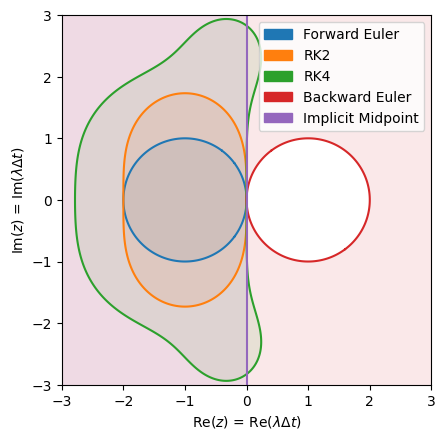

In [28]:
stable_regions(methods)

Let's apply the implicit midpoint method to the same stiff ODE as
before:

In [29]:
def implicit_midpoint(f, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    for _ in range(n):
        t = T[-1] + dt
        
        # Initial guess: Forward Euler estimate
        x0 = X[-1] + dt * f(X[-1], T[-1])

        # Define the implicit equation: x = x_last + dt * f(x_mid, t_mid)
        fim = lambda x: x - X[-1] - dt * f((X[-1]+x)/2, (T[-1]+t)/2)
                
        # Solve for x_next using Newton-Raphson (fsolve)
        x = fsolve(fim, x0)[0]
        
        X.append(x)
        T.append(t)
    return np.array(X), np.array(T)

In [30]:
# Parameters
x0 = 0
t0 = 0
tf = 0.01  # short time to observe stiffness effects
dt = 0.0025

T = np.linspace(t0, tf, 1000)
X = stiff_solution(T)

XfE, TfE = forwardEuler (stiff, x0, t0, dt, int((tf-t0)//dt))
XbE, TbE = backwardEuler(stiff, x0, t0, dt, int((tf-t0)//dt))
Xim, Tim = implicit_midpoint(stiff, x0, t0, dt, int((tf-t0)//dt))

/var/folders/l7/80r10g8s0yngwhynn3_dgrf400019j/T/ipykernel_11195/3606316028.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x = fsolve(fim, x0)[0]


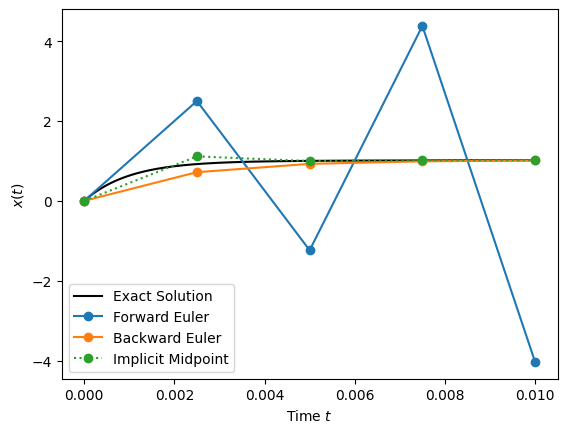

In [31]:
# Plotting
plt.plot(T,   X,   "k-",   label="Exact Solution")
plt.plot(TfE, XfE, "C0o-", label="Forward Euler")
plt.plot(TbE, XbE, "C1o-", label="Backward Euler")
plt.plot(Tim, Xim, "C2o:", label="Implicit Midpoint")
plt.xlabel(r"Time $t$")
plt.ylabel(r"$x(t)$")
plt.legend()

In [32]:
# HANDSON: adjust dt and tf to observe the behaviors of forward and
#          backward Euler methods.
#          Specifically, try dt = 0.002, < 0.002, and > 0.002.


In [33]:
# HANDSON: apply implicit midpoint method to the simple harmonic
#          oscillator problem.
#          Plot evolution of energy as function of time.


In [34]:
# HANDONS: create convergence plots to show the order of Euler and
#          implicit midpoint method for both the stiff problem and
#          harmonic oscillator problem.


From the above plots,
* Forward Euler:  unstable unless $\Delta t$ is tiny.
* Backward Euler: stable but introduces extra damping.
* Implicit midpoint: stable and preserves oscillatory features.

This balance of stability and geometric fidelity makes the implicit
midpoint method (also known as Crank-Nicolson) a popular scheme for
both stiff problems and Hamiltonian systems.

However, the implicit nature makes it less ideal for non-stiff
Hamiltonian systems.
There there methods that take advantage of Hamiltonian?

## Symplectic Algorithms

When simulating physical systems, especially those derived from
Hamiltonian mechanics, it is not enough for a numerical method to be
accurate and stable in the short term.
We also want to preserve the geometric structure of the system to
ensure that invariants such as energy and momentum remain bounded and
that phase-space volume is preserved.

Symplectic integrators are designed precisely for this purpose.
They preserve the symplectic structure of Hamiltonian flows, which
guarantees long-term qualitative fidelity, i.e.,
bounded oscillations,
stable orbits, and
correct statistical properties.

### Hamiltonian Systems

For a Hamiltonian
\begin{align}
  H(q,p) = T(p) + V(q)
\end{align}
with
* $q$: generalized coordinates (e.g. position).
* $p$: conjugate momenta.
* $T(p)$: kinetic energy.
* $V(q)$: potential energy.

The system's dynamics are governed by Hamilton's equations:
\begin{align}
  \frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad
  \frac{dp}{dt} = -\frac{\partial H}{\partial q}.
\end{align}

Examples of Hamiltonian system include:
* Simple harmonic oscillator:
  \begin{align}
  H(q,p) = \frac{p^2}{2m} + \frac{1}{2}k q^2
  \end{align}
* Kepler problem (planetary motion):
  \begin{align}
  H(q,p) = \frac{p^2}{2m} - \frac{GMm}{|q|}
  \end{align}

### Conservation Laws

Hamiltonian systems obey key invariants:
* Energy conservation:
  if $H$ is not explicitly time-dependent, $dH/dt = 0$.
* Momentum conservation:
  if $H$ does not depend on a coordinate $q_i$, the corresponding
  $p_i$ is conserved
  ([Noether's theorem](https://en.wikipedia.org/wiki/Noether%27s_theorem)).
* Phase-space volume preservation:
  Liouville's theorem states that Hamiltonian flows preserve volume in
  $(q,p)$ space.

### Why Symplectic Integrators?

* Standard methods (e.g. Forward Euler, RK4) often cause systematic
  drift in energy over long runs.
  In some sense, unstable schemes artificially inject energy to the
  system, while stable schemes (including RK4) artificially remove
  energy from the system.
* Symplectic integrators keep the energy error bounded and
  oscillatory, never drifting away permanently.
* This makes them especially valuable in:
  * Molecular dynamics (bounded energy in large ensembles).
  * Celestial mechanics (stable planetary orbits).
  * Long-term oscillator simulations.

### Symplectic Euler Method

The symplectic Euler method updates the coordinates and momenta in a
staggered fashion.
There are two variants of the Symplectic Euler method:
1. Implicit Symplectic Euler:
   \begin{align}
     p_{n+1} &= p_n - \Delta t \cdot \frac{\partial V}{\partial q}(q_{n}) \\
     q_{n+1} &= q_n + \Delta t \cdot \frac{p_{n+1}}{m}
   \end{align}
2. Explicit Symplectic Euler:
   \begin{align}
     q_{n+1} &= q_n + \Delta t \cdot \frac{p_n}{m} \\
     p_{n+1} &= p_n - \Delta t \cdot \frac{\partial V}{\partial q}(q_{n+1})
   \end{align}

As the formulation suggests, they are both first-order accurate in
time.
Nevertheless, compared to forward or even backward Euler methods, they
preserve the symplectic structure and ensure bounded energy errors.
They also offers better stability compared to non-symplectic explicit
methods.

In [35]:
# Symplectic Euler Method (Explicit Variant)

def symplecticEuler(F, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    
    for _ in range(n):
        q0, p0 = X[-1]
        t0     = T[-1]
        
        Hp, _  = F(X[-1], t0)
        q      = q0 + dt * Hp
        t      = t0 + dt
        
        _, mHq = F([q, p0], t)
        p      = p0 + dt * mHq
        
        X.append([q, p])
        T.append(t)
    return np.array(X), np.array(T)

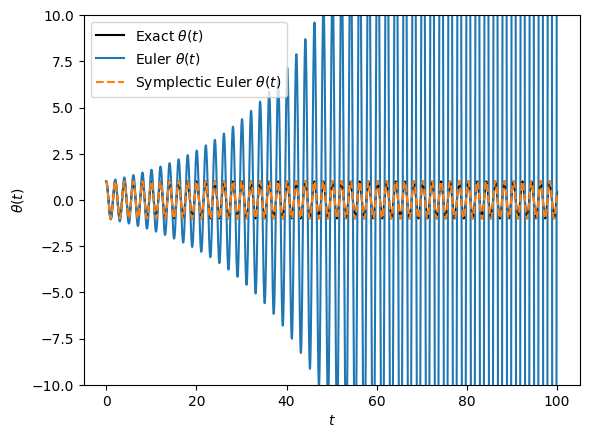

In [36]:
# Parameters
g, l = 9.8, 1
t, n = 100, 10000

T     = np.linspace(0, t, t*100+1)
Theta = sho_solution(T)

X1, T1 = forwardEuler(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta1, Omega1 = X1[:,0], X1[:,1]

X2, T2 = symplecticEuler(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta2, Omega2 = X2[:,0], X2[:,1]

plt.plot(T,  Theta,  'k',  label=r"Exact $\theta(t)$")
plt.plot(T1, Theta1,       label=r"Euler $\theta(t)$")
plt.plot(T2, Theta2, '--', label=r"Symplectic Euler $\theta(t)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\theta(t)$")
plt.ylim(-10, 10)
plt.legend()

In [37]:
# HANDSON: Adjust the above parameters to observe the behavior of
#          symplectic Euler.


In [38]:
# HANDONS: create convergence plots to show the order of symplectic
#          Euler method for the harmonic oscillator problem.


From the above plot, we observe:
* Forward Euler Method:
  * Behavior:
    Deviates significantly from the exact solution over time,
    exhibiting growing oscillations.
  * Reason:
    Non-symplectic nature causes energy to accumulate or dissipate
    artificially.
* Symplectic Euler Method:
  * Behavior:
    Maintains bounded energy errors, resulting in stable, oscillatory
    trajectories that closely follow the exact solution.
  * Reason:
    Preservation of the symplectic structure ensures that energy
    errors do not systematically drift.


### Leapfrog (Verlet) Integrator

The Leapfrog (or Verlet) method is one of the most widely used
symplectic integrators.
It improves upon symplectic Euler by achieving second-order accuracy
while still being explicit, symplectic, and time-reversible.

The key idea: positions $q$ and momenta $p$ are evaluated at staggered
time points, so that they "leapfrog" over each other.
This staggering ensures stability and bounded energy error, even over
very long simulations.

Leapfrog is especially important in molecular dynamics, celestial
mechanics, and $n$-body simulations, where millions of steps are
required to track conservative systems.

Start with Hamilton's equations:
\begin{align}
  \dot q = \frac{p}{m}, \qquad \dot p = f(q) = -\frac{\partial V}{\partial q}(q).
\end{align}

Momenta are updated on half steps:
\begin{align}
  p_{n+1/2} = p_{n-1/2} + f(q_n)\,\Delta t,
\end{align}
then positions are updated on integer steps:
\begin{align}
  q_{n+1} = q_n + \frac{1}{m} p_{n+1/2}\,\Delta t.
\end{align}

Thus $p$ "leapfrogs" over $q$, each using the other's most up-to-date
value.

#### Synchronized (velocity-Verlet) Form

To avoid half-step bookkeeping, we can write Leapfrog in a
synchronized form:
\begin{align}
  q_{n+1} &= q_n + \frac{1}{m}p_n \,\Delta t + \tfrac{1}{2m} f(q_n) \Delta t^2, \\
  p_{n+1} &= p_n + \tfrac{1}{2}\big(f(q_n) + f(q_{n+1})\big)\,\Delta t.
\end{align}

This form is known as velocity-Verlet, and is the most widely used in
practice.

#### Kick-Drift-Kick Form

Another equivalent rearrangement is the **kick-drift-kick** scheme:
\begin{align}
  p_{n+1/2} &= p_n + \tfrac{1}{2} f(q_n)\,\Delta t, \\
  q_{n+1}   &= q_n + \frac{1}{m}p_{n+1/2}\,\Delta t, \\
  p_{n+1}   &= p_{n+1/2} + \tfrac{1}{2} f(q_{n+1})\,\Delta t.
\end{align}
This is especially convenient if time steps are adaptive, because only
one new force evaluation is needed per step.

In [39]:
# Symplectic Euler Method (Explicit Variant)

def leapfrog(F, x, t, dt, n):
    X = [np.array(x)]
    T = [np.array(t)]
    
    for _ in range(n):
        q0, p0 = X[-1]
        t0     = T[-1]

        _, mHq = F(X[-1], t0)
        ph     = p0 + 0.5*dt * mHq
        th     = p0 + 0.5*dt
        
        Hp, _  = F([q0, ph], th)
        q      = q0 + dt * Hp
        t      = t0 + dt
        
        _, mHq = F([q, ph], t)
        p      = ph + 0.5*dt * mHq
        
        X.append([q, p])
        T.append(t)
    return np.array(X), np.array(T)

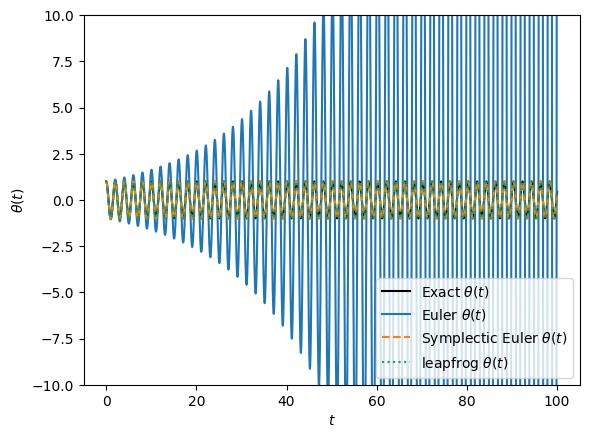

In [40]:
# Parameters
t, n = 100, 10000

T     = np.linspace(0, t, t*100+1)
Theta = sho_solution(T)

X1, T1 = forwardEuler(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta1, Omega1 = X1[:,0], X1[:,1]

X2, T2 = symplecticEuler(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta2, Omega2 = X2[:,0], X2[:,1]

X3, T3 = leapfrog(Sho, x=[1.0, 0.0], t=0, dt=t/n, n=n)
Theta3, Omega3 = X3[:,0], X3[:,1]

plt.plot(T,  Theta,  'k',  label=r"Exact $\theta(t)$")
plt.plot(T1, Theta1,       label=r"Euler $\theta(t)$")
plt.plot(T2, Theta2, '--', label=r"Symplectic Euler $\theta(t)$")
plt.plot(T3, Theta3, ':',  label=r"leapfrog $\theta(t)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\theta(t)$")
plt.ylim(-10, 10)
plt.legend()

In [41]:
# HANDSON: Adjust the above parameters to observe the behavior of
#          leapfrog.


In [42]:
# HANDONS: create convergence plots to show the order of symplectic
#          Euler and leapfrog method for the harmonic oscillator
#          problem.


In [43]:
# HANDONS: use autodiff (e.g., JAX) to compute $\partial H/\partial q$
#          and $\partial H/\partial p$.


The Leapfrog integrator is:
* Accuracy:
  Second-order in $\Delta t$ (vs. first-order for Symplectic Euler).
* Symplectic:
  Preserves the Hamiltonian structure, ensuring bounded energy error.
* Time-reversible:
  Running with $+\Delta t$ then $-\Delta t$ recovers the initial state
  exactly.
* Stability:
  Stable for oscillatory motion provided $\Delta t < 2/\omega$
  (where $\omega$ is the oscillator frequency).

### Derivation and Preservation of Symplectic Structure

So far, we have observed that symplectic integrators behave
differently:
they keep energy bounded,
preserve phase-space volume, and
remain stable over long times.
But *why* does this happen?

The answer lies in their ability to preserve the symplectic structure
of Hamiltonian systems.
This structure encodes both the conservation laws (via Noether's
theorem) and Liouville's theorem (phase-space volume preservation).
Understanding how an algorithm preserves this structure explains why
symplectic methods are uniquely powerful.

For a separable Hamiltonian
\begin{align}
  H(q,p) = \frac{p^2}{2m} + V(q),
\end{align}
Hamilton's equations are
\begin{align}
  \dot q = \frac{\partial H}{\partial p} = \frac{p}{m},
  \qquad
  \dot p = -\frac{\partial H}{\partial q} = -V'(q).
\end{align}

A one-step method can be written as a map
\begin{align}
  (q_n, p_n) \mapsto (q_{n+1}, p_{n+1}).
\end{align}

For symplectic Euler:
\begin{align}
  q_{n+1} &= q_n + \tfrac{\Delta t}{m} p_n, \\
  p_{n+1} &= p_n - \Delta t \, V'(q_{n+1}).
\end{align}

The Jacobian of this transformation is
\begin{align}
  J =
  \begin{pmatrix}
  \frac{\partial q_{n+1}}{\partial q_n} & \frac{\partial q_{n+1}}{\partial p_n} \\
  \frac{\partial p_{n+1}}{\partial q_n} & \frac{\partial p_{n+1}}{\partial p_n}
  \end{pmatrix}
  =
  \begin{pmatrix}
  1 & \tfrac{\Delta t}{m} \\
  - \Delta t \, V''(q_{n+1}) & 1 - \tfrac{\Delta t^2}{m} V''(q_{n+1})
  \end{pmatrix}.
\end{align}

A method is symplectic if this Jacobian preserves the canonical
2-form:
\begin{align}
  J^T \Omega J = \Omega,
  \quad \text{where}
  \quad \Omega =
  \begin{pmatrix}
     0 & 1 \\
    -1 & 0
  \end{pmatrix}.
\end{align}
Carrying out the matrix multiplication confirms that the symplectic
condition holds.
Thus symplectic Euler is indeed symplectic.


The geometric interpretations here are:
* Symplecticity means the numerical flow preserves the geometry of
  Hamiltonian mechanics.
  Phase-space volume is preserved exactly, and invariants such as
  energy remain bounded.
* Contrast with non-symplectic methods:
  Forward Euler and RK4 distort the phase-space geometry, leading to
  secular energy drift.
* Discrete Hamiltonian Flow:
  Symplectic integrators can be interpreted as approximating a nearby
  Hamiltonian system rather than the exact one.
  This explains why energy error oscillates but does not drift.

Some practical considerations for using symplectic intergrators
include:
* Choosing $\Delta t$:
  Symplectic integrators allow larger steps than non-symplectic ones,
  but accuracy still requires $\Delta t$ small enough to resolve the
  dynamics.
* Nonlinear forces:
  For nonlinear $V(q)$, implicit symplectic schemes (e.g. implicit
  midpoint) may require solving nonlinear equations each step.
* Adaptive time-stepping:
  Standard symplectic schemes assume constant $\Delta t$.
  Adaptive step sizes break symplecticity, though specialized adaptive
  symplectic schemes exist.

## Summary

* Symplectic integrators preserve the symplectic two-form, ensuring
  phase-space volume conservation and bounded energy error.
* This explains their excellent long-term stability, especially for
  Hamiltonian systems like oscillators and planetary motion.
* Examples:
  * Symplectic Euler:
    first-order, simple, symplectic but not time-symmetric.
  * Leapfrog/Verlet:
    second-order, symplectic *and* time-symmetric, widely used in
    practice.
* Unlike standard explicit methods, symplectic schemes are not just
  about minimizing local error.
  They preserve the very geometry of Hamiltonian dynamics.
  Interesting connection to
  [discrete differential geometry](https://en.wikipedia.org/wiki/Discrete_differential_geometry).